# Training file for UpscaleNN

## Imports

In [1]:
import src.nntools as nt
from src.CarlaDataset import CarlaDatasetPatch
from src.PytorchUtil import PytorchUtil as torchUtil

from src.UpscaleNN import UpscaleResidualNN as UpscaleNN

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()


if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

print(device)

2023-12-05 14:41:15.866202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 14:41:15.866230: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 14:41:15.866251: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 14:41:15.871232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


cuda


# Utility function

In [2]:
class SuperResolutionStatsManager(nt.StatsManager):
    def __init__(self):
        super(SuperResolutionStatsManager, self).__init__()

    def init(self):
        super(SuperResolutionStatsManager, self).init()
        # Initializing `self.running_psnr`
        self.running_psnr = 0
        self.running_ssim = 0

    def accumulate(self, loss, x, y, d):
        super(SuperResolutionStatsManager, self).accumulate(loss, x, y, d)
        # Updating `self.running_psnr`
        d_numpy = d.detach().to('cpu').numpy()
        y_numpy = y.detach().to('cpu').numpy()

        self.running_psnr += metrics.peak_signal_noise_ratio(d_numpy, y_numpy)

        current_ssim = 0

        for i in range(d_numpy.shape[0]):
            d_numpy_temp = np.moveaxis(d_numpy[i], [0, 1, 2], [2, 0, 1])
            y_numpy_temp = np.moveaxis(y_numpy[i], [0, 1, 2], [2, 0, 1])

            value_range = max(d_numpy_temp.max(), y_numpy_temp.max()) - min(d_numpy_temp.min(), y_numpy_temp.min())
            
            current_ssim += metrics.structural_similarity(d_numpy_temp, y_numpy_temp, win_size=7, data_range=value_range, multichannel=True, channel_axis=2)
        
        self.running_ssim += current_ssim / d_numpy.shape[0]

    def summarize(self):
        loss = super(SuperResolutionStatsManager, self).summarize()
        psnr = self.running_psnr / (self.number_update+1e-9 )
        ssim = self.running_ssim / (self.number_update+1e-9 )
        return {'loss': loss, 'psnr': psnr, "ssim": ssim}

def criterion(y, d):
    return F.mse_loss(y, d)

#show image
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    # ax.axis('off')
    return h

## Data loader

In [3]:
new_img_size = 256
common_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    common_transform,
    #transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(size=(new_img_size, new_img_size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
])

valid_transform = transforms.Compose([
    common_transform,
    #transforms.CenterCrop((new_img_size, new_img_size)),
])

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import your datasetclass

PATCH_SIZE = 32

full_train_dataset = CarlaDatasetPatch("1920x1080", "960x540", "train", transforms=train_transform, download=True, patch_size=PATCH_SIZE)
full_test_dataset = CarlaDatasetPatch("1920x1080", "960x540", "test", transforms=train_transform, download=True, patch_size=PATCH_SIZE)

train_dataset_patched = CarlaDatasetPatch("1920x1080", "960x540", "train", transforms=train_transform, download=True, patch_size=PATCH_SIZE)
test_dataset_patched = CarlaDatasetPatch("1920x1080", "960x540", "test", transforms=train_transform, download=True, patch_size=PATCH_SIZE)

SUBSET_SIZE = 20000
if len(train_dataset_patched) > SUBSET_SIZE:
    train_dataset_patched.limit_dataset(SUBSET_SIZE)

if len(test_dataset_patched) > SUBSET_SIZE * 0.2:
    test_dataset_patched.limit_dataset(int(SUBSET_SIZE * 0.2))

print("Size of sub train dataset", len(train_dataset_patched))
print("Size of sub test dataset", len(test_dataset_patched))

Dataset already present
Dataset already present
Dataset already present
Dataset already present
Size of sub train dataset 20000
Size of sub test dataset 4000


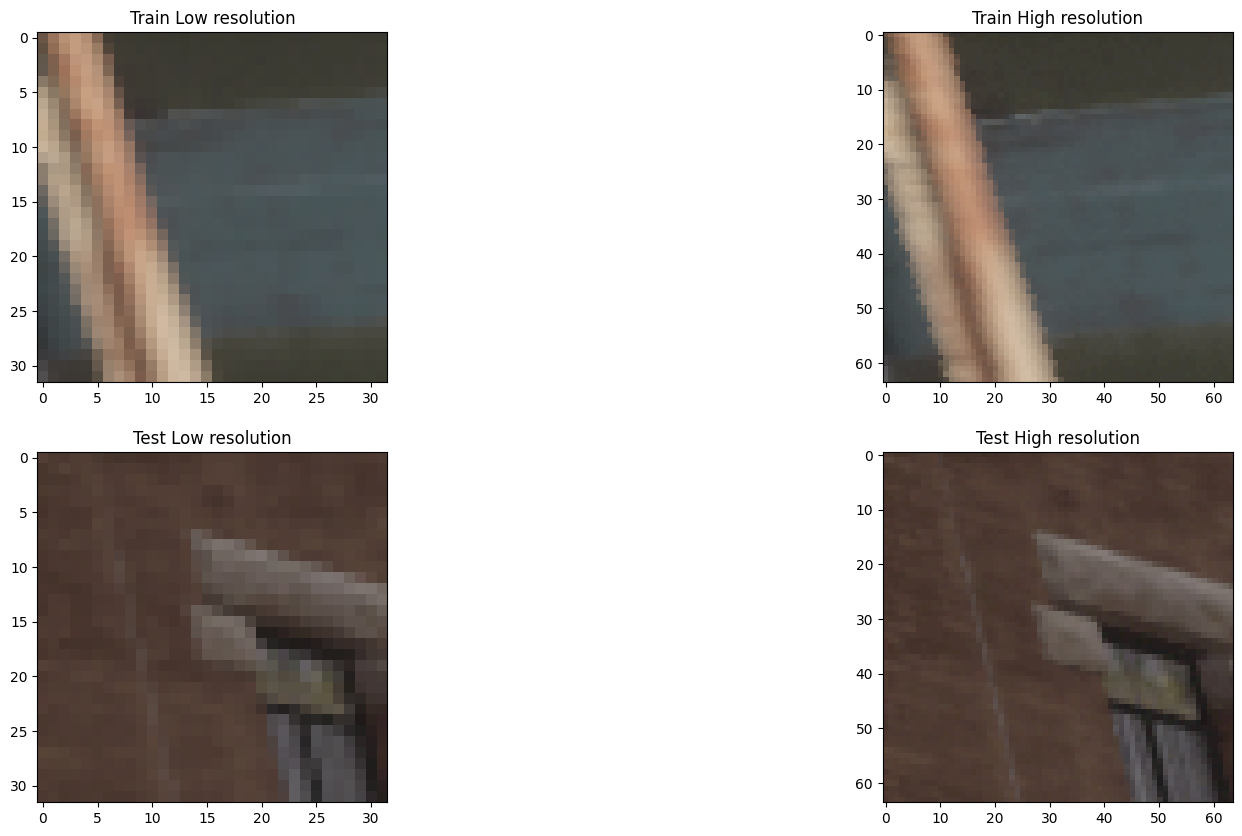

In [5]:
# Show one full image for both train and test
example1_low, example1_high = full_train_dataset[0]
example2_low, example2_high = full_test_dataset[0]

example1_low_image = torchUtil.tensor_to_image(example1_low)
example1_high_image = torchUtil.tensor_to_image(example1_high)

example2_low_image = torchUtil.tensor_to_image(example2_low)
example2_high_image = torchUtil.tensor_to_image(example2_high)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].imshow(example1_low_image)
ax[0, 0].set_title("Train Low resolution")
ax[0, 1].imshow(example1_high_image)
ax[0, 1].set_title("Train High resolution")
ax[1, 0].imshow(example2_low_image)
ax[1, 0].set_title("Test Low resolution")
ax[1, 1].imshow(example2_high_image)
ax[1, 1].set_title("Test High resolution")

plt.show()

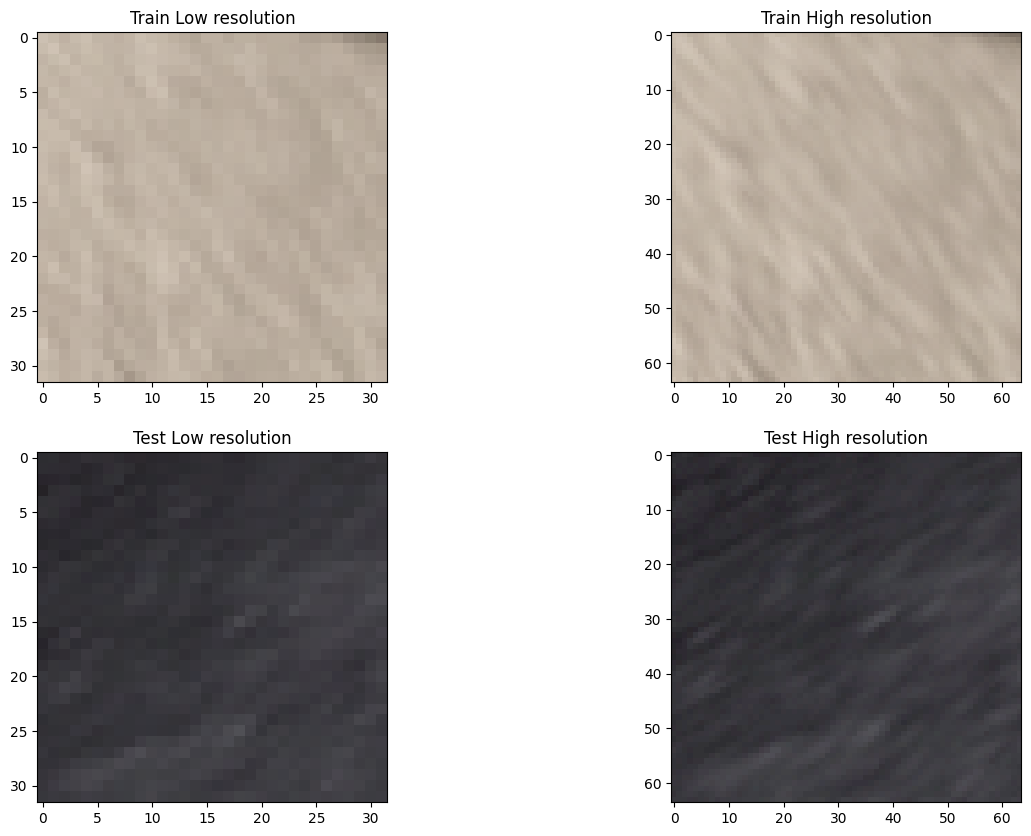

In [6]:
# Do the same for the patched dataset
example1_low, example1_high = train_dataset_patched[0]
example2_low, example2_high = test_dataset_patched[0]

example1_low_image = torchUtil.tensor_to_image(example1_low)
example1_high_image = torchUtil.tensor_to_image(example1_high)

example2_low_image = torchUtil.tensor_to_image(example2_low)
example2_high_image = torchUtil.tensor_to_image(example2_high)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].imshow(example1_low_image)
ax[0, 0].set_title("Train Low resolution")
ax[0, 1].imshow(example1_high_image)
ax[0, 1].set_title("Train High resolution")
ax[1, 0].imshow(example2_low_image)
ax[1, 0].set_title("Test Low resolution")
ax[1, 1].imshow(example2_high_image)
ax[1, 1].set_title("Test High resolution")

plt.show()

In [7]:
# Plot for the the predicted image, low resolution image and high resolution image in first row
# plot Plot the loss, psnr and ssim curves in the second row
def plot_images_and_metrics(exp, fig, axes, dataset, index): ##Only to use when perform_validation_during_training == True
    low_res, high_res = dataset[index]

    with torch.no_grad():
        predicted_res = exp.net(low_res.to(device))[0]

    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    axes[1][2].clear()

    low_res_image = torchUtil.tensor_to_image(low_res)
    high_res_image = torchUtil.tensor_to_image(high_res)
    predicted_res_image = torchUtil.tensor_to_image(predicted_res)

    axes[0][0].set_title(f'Low res: {low_res_image.shape}')
    axes[0][1].set_title(f'High res: {high_res_image.shape}')
    axes[0][2].set_title(f'Predicted res: {predicted_res_image.shape}')


    axes[0][0].imshow(low_res_image)
    axes[0][1].imshow(high_res_image)
    axes[0][2].imshow(predicted_res_image)

    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="Train loss")
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="Train psnr")
    axes[1][2].plot([exp.history[k][0]['ssim'] for k in range(exp.epoch)], label="Train ssim")

    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="Eval loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], label="Eval psnr")
    axes[1][2].plot([exp.history[k][1]['ssim'] for k in range(exp.epoch)], label="Eval ssim")

    axes[1][0].legend()
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")        
    axes[1][1].legend()
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR") 
    axes[1][2].legend()
    axes[1][2].set_xlabel("Epoch")
    axes[1][2].set_ylabel("SSIM")

## Training a model on a small dataset 

In [8]:
small_dataset_size = 30
small_dataset = [train_dataset_patched[np.random.randint(len(train_dataset_patched))] for _ in range(small_dataset_size)]

small_train_size = int(0.8 * len(small_dataset))
small_valid_size = len(small_dataset) - small_train_size
small_train_dataset, small_valid_dataset = torch.utils.data.random_split(small_dataset, [small_train_size, small_valid_size])

print("Size of small_train_dataset:", len(small_train_dataset))

Size of small_train_dataset: 24


In [9]:
lr = 1e-3

torch.cuda.empty_cache()
r = UpscaleNN()
r = r.to(device)
# In mega bytes
print("Size of model mb", sum(p.numel() for p in r.parameters() if p.requires_grad) / (1024 * 1024))
# Size of batch in mega bytes
print("Size of batch mb", small_dataset[0][0].shape[0] * small_dataset[0][0].shape[1] * small_dataset[0][0].shape[2] * 4 / (1024 * 1024))

adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
path = "results/smallbatchexperiment-upscale-resid"
exp = nt.Experiment(r, 
                    small_dataset, small_valid_dataset, 
                    adam, stats_manager, device, criterion, batch_size=1,
                    output_dir=path, perform_validation_during_training=True)

# Show number of parameters
print("Number of parameters:", sum(p.numel() for p in r.parameters() if p.requires_grad))

Size of model mb 0.17947101593017578
Size of batch mb 0.01171875
Number of parameters: 188189


Start/Continue training from epoch 300
Finish training for 300 epochs


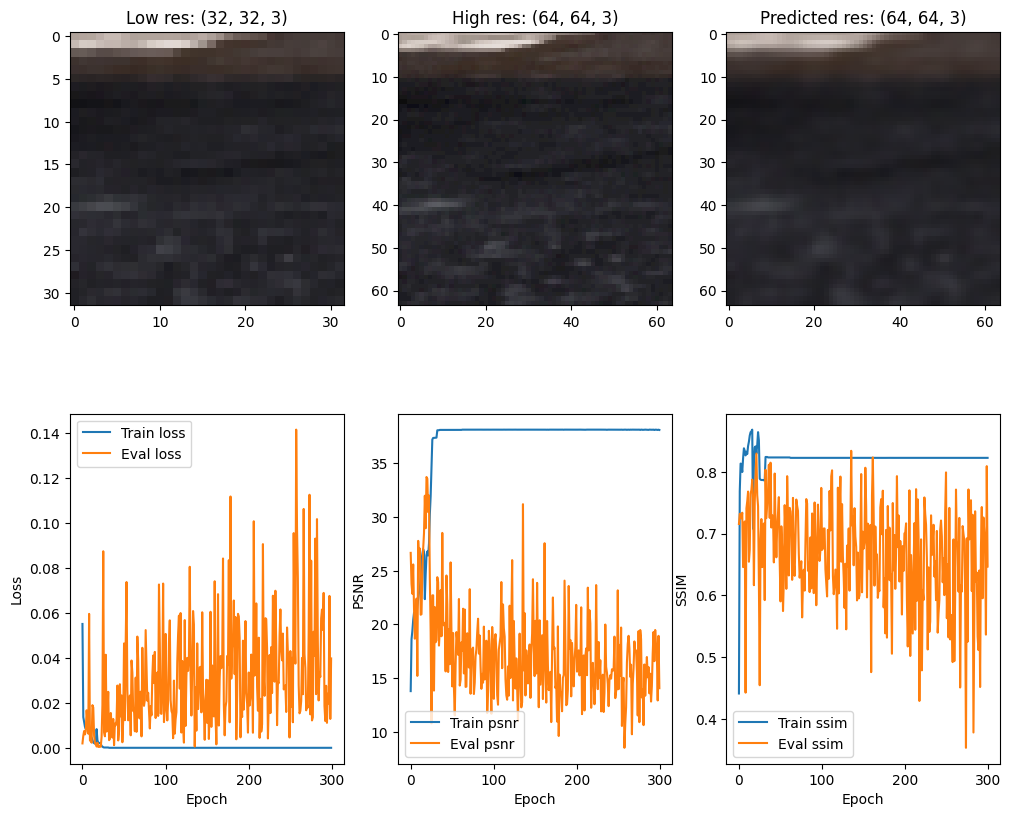

In [10]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 10))
exp.run(num_epochs=300, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, small_valid_dataset, np.random.randint(len(small_valid_dataset))))

In [11]:
# Show three images for a set and predict it
def plot_images_from_model(model, dataset, num_images=1, indices=None):
    num_images = max(num_images, len(indices) if indices else 0)

    _, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))

    for i in range(num_images):
        if indices:
            low_res, high_res = dataset[indices[i]]
            print("Chosen index", indices[i])
        else:
            index = np.random.randint(len(dataset))
            low_res, high_res = dataset[index]
            print("Chosen index", index)

        with torch.no_grad():
            predicted_res = model.net(low_res.to(device))[0]

        low_res_image = torchUtil.tensor_to_image(low_res)
        high_res_image = torchUtil.tensor_to_image(high_res)
        predicted_res_image = torchUtil.numpy_to_image(torchUtil.tensor_to_numpy(predicted_res))

        axes[i, 0].set_title(f'Low res: {low_res_image.shape}')
        axes[i, 1].set_title(f'High res: {high_res_image.shape}')
        axes[i, 2].set_title(f'Predicted res: {predicted_res_image.shape}')

        axes[i, 0].imshow(low_res_image)
        axes[i, 1].imshow(high_res_image)
        axes[i, 2].imshow(predicted_res_image)
    
    plt.show()

In [12]:
from torchvision.transforms.v2 import Resize

def resize_tensor(tensor, size):
    return Resize(size, antialias=True)(tensor)

def resize_tensor_to_numpy(tensor, size):
    return torchUtil.tensor_to_numpy(resize_tensor(tensor, size))

def plot_predicted_and_billinear(model, dataset, num_images=1, indices=None):
    num_images = max(num_images, len(indices) if indices else 0)

    _, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))

    for i in range(num_images):
        if indices:
            low_res, _ = dataset[indices[i]]
            print("Chosen index", indices[i])
        else:
            index = np.random.randint(len(dataset))
            low_res, _ = dataset[index]
            print("Chosen index", index)

        with torch.no_grad():
            predicted_torch = model.net(low_res.to(device))[0]

        predicted_res = torchUtil.tensor_to_numpy(predicted_torch)
                    
        bilinear_image = resize_tensor_to_numpy(low_res, (predicted_res.shape[0], predicted_res.shape[1]))
        subtraction_image = torchUtil.norm_numpy_image(predicted_res - bilinear_image)

        print(subtraction_image.mean(), subtraction_image.std())

        axes[i, 0].set_title(f'Predicted res: {predicted_res.shape}')
        axes[i, 1].set_title(f'Bilinear res: {bilinear_image.shape}')
        axes[i, 2].set_title(f'Substraction res: {subtraction_image.shape}')

        axes[i, 0].imshow(torchUtil.numpy_to_image(predicted_res), vmin=0, vmax=1)
        axes[i, 1].imshow(torchUtil.numpy_to_image(bilinear_image), vmin=0, vmax=1)
        axes[i, 2].imshow(torchUtil.numpy_to_image(subtraction_image), vmin=subtraction_image.min(), vmax=subtraction_image.max())  
    
    plt.show()

Chosen index 0
Chosen index 1
Chosen index 2


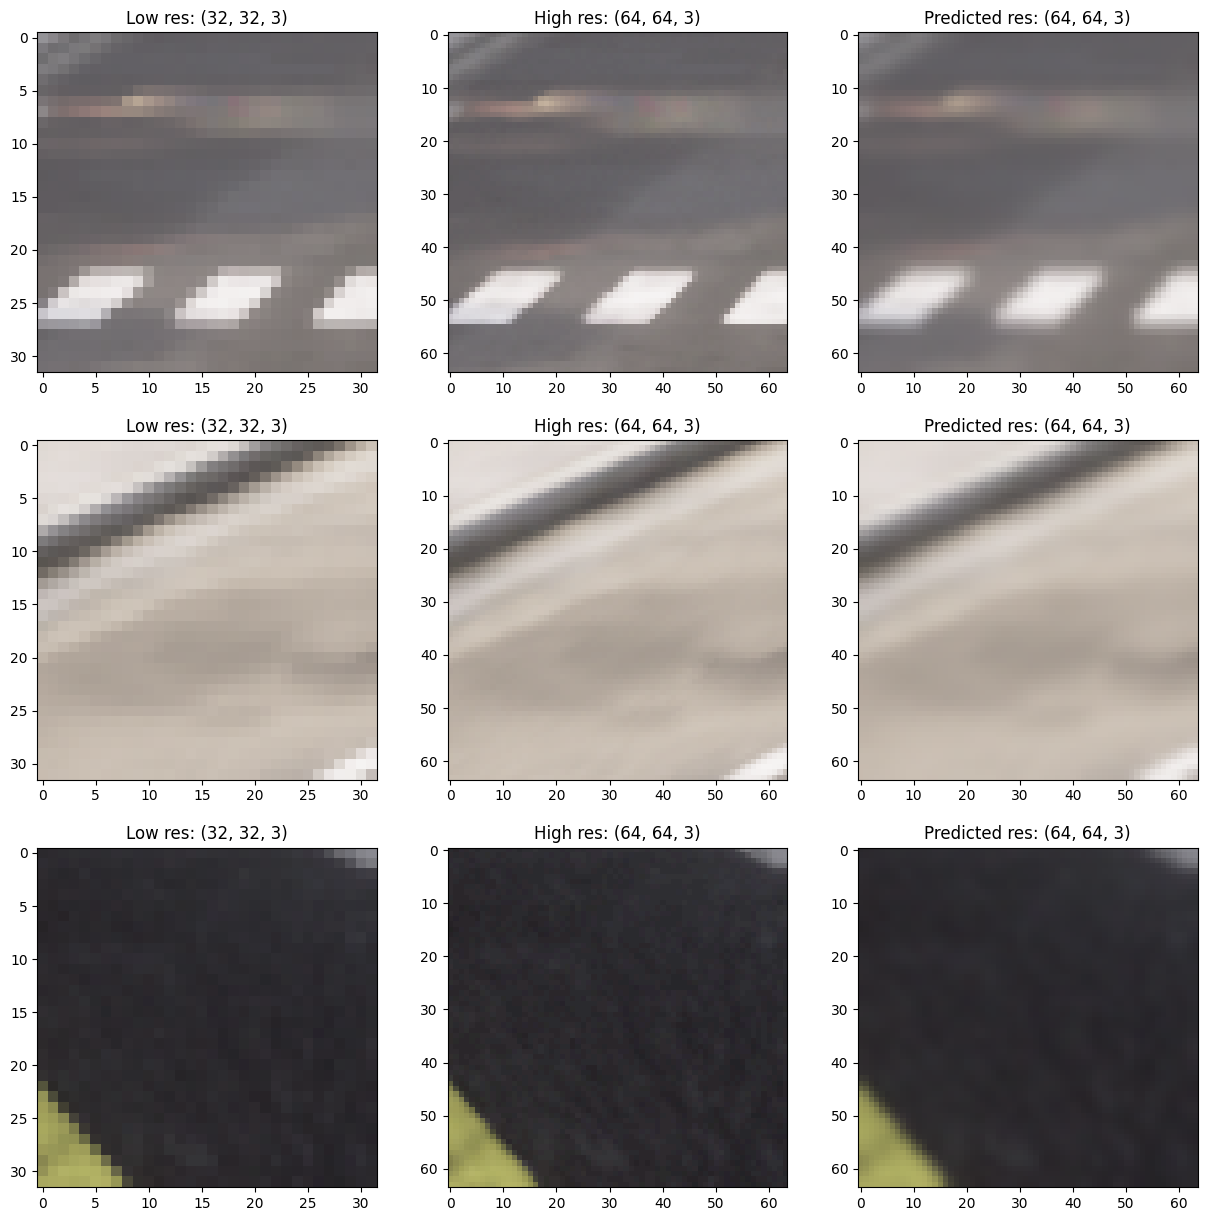

Chosen index 0
0.58369374 0.4250599
Chosen index 1
0.58369374 0.4250599
Chosen index 2
0.5836938 0.4250251


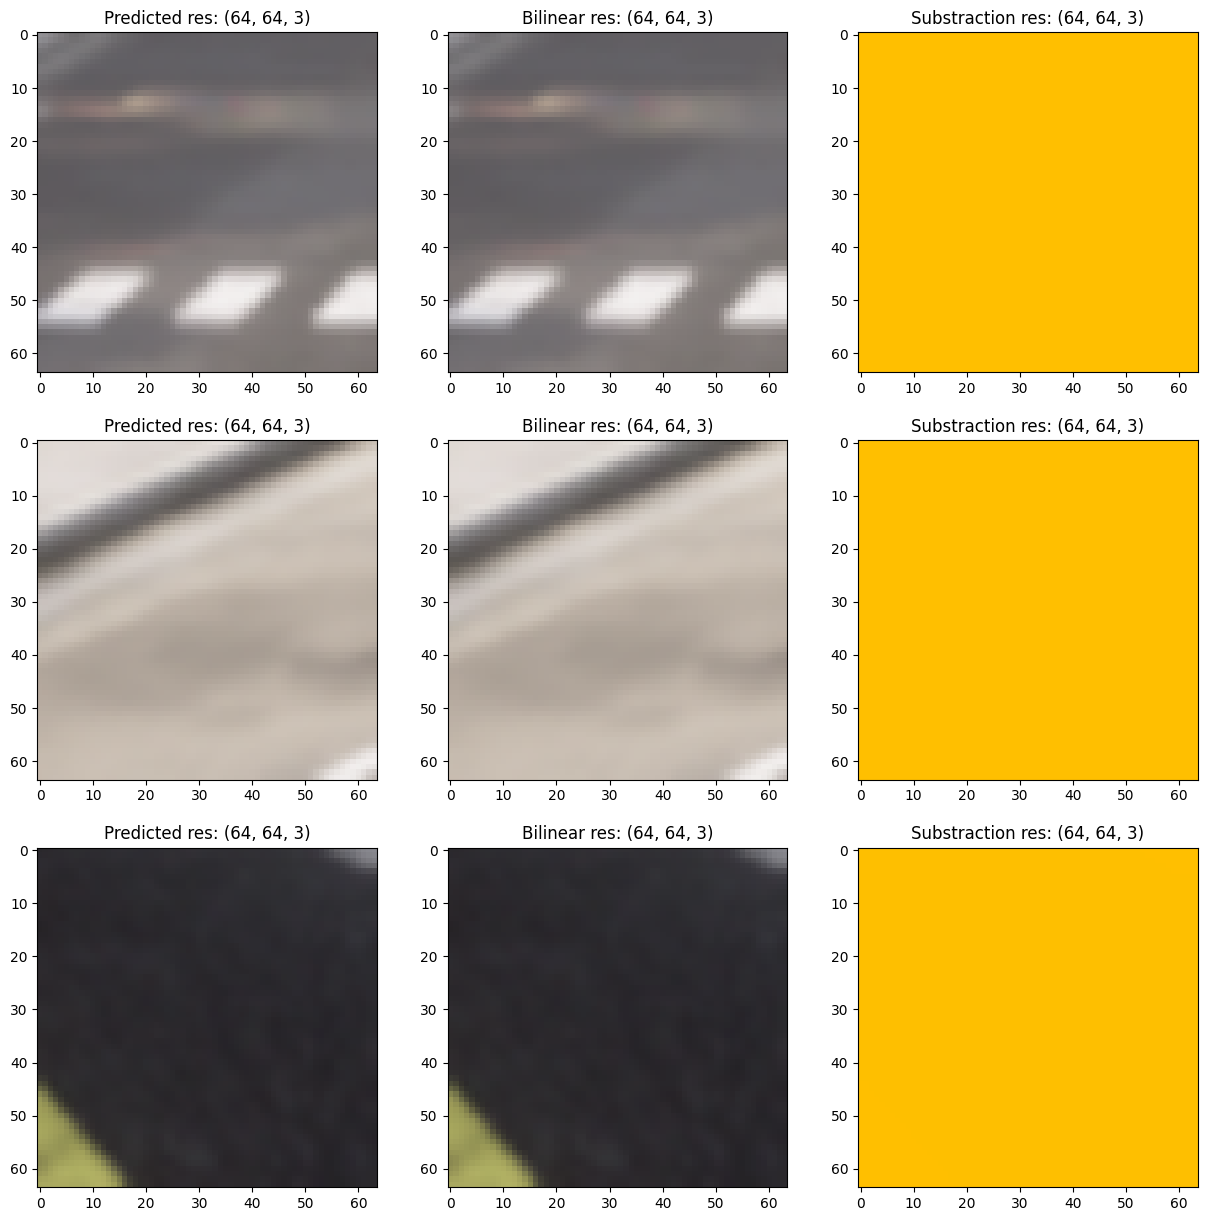

In [13]:
plot_images_from_model(exp, small_dataset, indices=[0, 1, 2])

plot_predicted_and_billinear(exp, small_dataset, indices=[0, 1, 2])

# Training a model on a subsequent part of the original dataset

In [14]:

# Take the sub part of the dataset from random indices
train_size = int(0.8 * len(train_dataset_patched))
valid_size = len(train_dataset_patched) - train_size

train_sub_dataset, valid_sub_dataset = torch.utils.data.random_split(train_dataset_patched, [train_size, valid_size])

print("Size of train_dataset: ", len(train_sub_dataset))
print("Size of valid_dataset: ", len(valid_sub_dataset))

Size of train_dataset:  16000
Size of valid_dataset:  4000


In [15]:
lr = 1e-3
batch_size = 512

torch.cuda.empty_cache()
r = UpscaleNN()
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
path = "results/superresol-upscale-resid"
exp1 = nt.Experiment(r, 
                    train_sub_dataset, valid_sub_dataset, 
                    adam, stats_manager, device, criterion, 
                    batch_size=batch_size,
                    output_dir=path, perform_validation_during_training=True)

In [16]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
exp1.run(num_epochs=60, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, test_dataset_patched, np.random.randint(len(test_dataset_patched))))
#exp1.run(num_epochs=3, plot=None)

Start/Continue training from epoch 0


In [ ]:
plot_images_from_model(exp1, test_dataset_patched, num_images=4)

In [ ]:
plot_images_from_model(exp1, test_dataset_patched, num_images=4)


plot_predicted_and_billinear(exp, test_dataset_patched, num_images=4)

# Reconstruct image from patch

In [ ]:
from src.PatchImageTool import PatchImageTool

index_patch_train = np.random.randint(len(full_train_dataset))
index_patch_test = np.random.randint(len(full_test_dataset))

print("Choose index train", index_patch_train, "Choose index test", index_patch_test)

start_index_patch_train = full_train_dataset.get_index_start_patch(index_patch_train)
start_index_patch_test = full_test_dataset.get_index_start_patch(index_patch_test)

print ("Start index patch train", start_index_patch_train, "Start index patch test", start_index_patch_test)

index_train = full_train_dataset.get_index_for_image(index_patch_train)
index_test = full_test_dataset.get_index_for_image(index_patch_test)

print ("Index train", index_train, "Index test", index_test)

train_low_res, train_high_res = full_train_dataset.get_full_image(index_train)
test_low_res, test_high_res = full_test_dataset.get_full_image(index_test)

pred_high_res1 = PatchImageTool.predict_image_from_dataset_patches(exp1, (1920, 1080), full_train_dataset, index_patch_train, device)
pred_high_res2 = PatchImageTool.predict_image_from_dataset_patches(exp1, (1920, 1080), full_test_dataset, index_patch_test, device)

In [ ]:
## Test on one image from the train and test set

fig, axes = plt.subplots(2, 3, figsize=(30, 10))

train_low_res_image = torchUtil.tensor_to_image(train_low_res)
train_high_res_image = torchUtil.tensor_to_image(train_high_res)
pred_high_res1_image = torchUtil.tensor_to_image(pred_high_res1)

axes[0][0].set_title(f'Train Low res: {train_low_res_image.shape}')
axes[0][1].set_title(f'Train High res: {train_high_res_image.shape}')
axes[0][2].set_title(f'Train Predicted res: {pred_high_res1_image.shape}')

axes[0][0].imshow(train_low_res_image)
axes[0][1].imshow(train_high_res_image)
axes[0][2].imshow(pred_high_res1_image)

test_low_res_image = torchUtil.tensor_to_image(test_low_res)
test_high_res_image = torchUtil.tensor_to_image(test_high_res)
pred_high_res2_image = torchUtil.tensor_to_image(pred_high_res2)

axes[1][0].set_title(f'Test Low res: {test_low_res.shape}')
axes[1][1].set_title(f'Test High res: {test_high_res.shape}')
axes[1][2].set_title(f'Test Predicted res: {pred_high_res2_image.shape}')

axes[1][0].imshow(test_low_res_image)
axes[1][1].imshow(test_high_res_image)
axes[1][2].imshow(pred_high_res2_image)

plt.show()

In [ ]:
# Show predicted, bilinear and subtraction image

fig, axes = plt.subplots(2, 3, figsize=(30, 10))

pred_high_res1_numpy = torchUtil.tensor_to_numpy(pred_high_res1)
pred_high_res2_numpy = torchUtil.tensor_to_numpy(pred_high_res2)

bilinear_image1_numpy = resize_tensor_to_numpy(train_low_res, (pred_high_res1_image.shape[0], pred_high_res1_image.shape[1]))
bilinear_image2_numpy = resize_tensor_to_numpy(test_low_res, (pred_high_res2_image.shape[0], pred_high_res2_image.shape[1]))

subtraction_numpy = torchUtil.norm_numpy_image(pred_high_res1_numpy - bilinear_image1_numpy)
subtraction_numpy =  torchUtil.norm_numpy_image(pred_high_res2_numpy - bilinear_image2_numpy)

axes[0][0].set_title(f'Train Predicted res: {pred_high_res1_image.shape}')
axes[0][1].set_title(f'Train Bilinear res: {bilinear_image1_numpy.shape}')
axes[0][2].set_title(f'Train Subtraction res: {subtraction_numpy.shape}')

axes[0][0].imshow(torchUtil.numpy_to_image(pred_high_res1_image), vmin=0, vmax=1)
axes[0][1].imshow(torchUtil.numpy_to_image(bilinear_image1_numpy), vmin=0, vmax=1)
axes[0][2].imshow(torchUtil.numpy_to_image(subtraction_numpy), vmin=subtraction_numpy.min(), vmax=subtraction_numpy.max())

axes[1][0].set_title(f'Test Predicted res: {pred_high_res2_image.shape}')
axes[1][1].set_title(f'Test Bilinear res: {bilinear_image2_numpy.shape}')

axes[1][2].set_title(f'Test Subtraction res: {subtraction_numpy.shape}')

axes[1][0].imshow(torchUtil.numpy_to_image(pred_high_res2_image), vmin=0, vmax=1)
axes[1][1].imshow(torchUtil.numpy_to_image(bilinear_image2_numpy), vmin=0, vmax=1)
axes[1][2].imshow(torchUtil.numpy_to_image(subtraction_numpy), vmin=subtraction_numpy.min(), vmax=subtraction_numpy.max())

plt.show()

In [ ]:
# Compute the PSNR and SSIM for the predicted image

train_high_res_np = torchUtil.tensor_to_numpy(train_high_res)
test_high_res_np = torchUtil.tensor_to_numpy(test_high_res)

pred_high_res1_np = torchUtil.tensor_to_numpy(pred_high_res1)
pred_high_res2_np = torchUtil.tensor_to_numpy(pred_high_res2)

train_psnr = metrics.peak_signal_noise_ratio(train_high_res_np, pred_high_res1_np)
train_ssim = metrics.structural_similarity(train_high_res_np, pred_high_res1_np, win_size=7, data_range=1, multichannel=True, channel_axis=2)

test_psnr = metrics.peak_signal_noise_ratio(test_high_res_np, pred_high_res2_np)
test_ssim = metrics.structural_similarity(test_high_res_np, pred_high_res2_np, win_size=7, data_range=1, multichannel=True, channel_axis=2)

print("Train PSNR", train_psnr, "Train SSIM", train_ssim)
print("Test PSNR", test_psnr, "Test SSIM", test_ssim)

# Compute the PSNR and SSIM for the bilinear image

train_bilinear_psnr = metrics.peak_signal_noise_ratio(train_high_res_np, bilinear_image1_numpy)
train_bilinear_ssim = metrics.structural_similarity(train_high_res_np, bilinear_image1_numpy, win_size=7, data_range=1, multichannel=True, channel_axis=2)

test_bilinear_psnr = metrics.peak_signal_noise_ratio(test_high_res_np, bilinear_image2_numpy)
test_bilinear_ssim = metrics.structural_similarity(test_high_res_np, bilinear_image2_numpy, win_size=7, data_range=1, multichannel=True, channel_axis=2)

print()
print("Train bilinear PSNR", train_bilinear_psnr, "Train bilinear SSIM", train_bilinear_ssim)
print("Test bilinear PSNR", test_bilinear_psnr, "Test bilinear SSIM", test_bilinear_ssim)

In [ ]:
sub_dataset_size = 10

# Compute the PSNR and SSIM for the predicted image on a subset of the train set
train_psnr, train_ssim = PatchImageTool.compute_metrics_dataset(exp1, full_train_dataset, sub_dataset_size, (1920, 1080), device)

# Compute the PSNR and SSIM for the predicted image on a subset of the test set
test_psnr, test_ssim = PatchImageTool.compute_metrics_dataset(exp1, full_test_dataset, sub_dataset_size, (1920, 1080), device)

print()
print("PSNR scores for test images, mean : ", test_psnr.mean(), ", var :", test_psnr.var())
print("Average SSIM for test images, mean : ", test_ssim.mean(), ", var :", test_ssim.var())

print("Average PSNR for train images, mean : ", train_psnr.mean(), ", var :", train_psnr.var())
print("Average SSIM for train images, mean : ", train_ssim.mean(), ", var :", train_ssim.var())

In [ ]:
# Test on 20 images from the test set
sub_dataset_size = 20
indices = np.random.choice(len(full_test_dataset), sub_dataset_size, replace=False)
predicted_images = PatchImageTool.predict_images_from_dataset_patches(exp1, (1920, 1080), full_test_dataset, indices, device)

In [ ]:
# Show 4 images, real vs predicted

fig, axes = plt.subplots(4, 3, figsize=(30, 20))

for i in range(4):
    index = indices[i]
    image_index = full_test_dataset.get_index_for_image(index)

    low_res, high_res = full_test_dataset.get_full_image(image_index)

    low_res_image = torchUtil.tensor_to_image(low_res)
    high_res_image = torchUtil.tensor_to_image(high_res)
    pred_high_res_image = torchUtil.tensor_to_image(predicted_images[i])
    
    axes[i][0].set_title(f'Low res: {low_res_image.shape}')
    axes[i][1].set_title(f'High res: {high_res_image.shape}')
    axes[i][2].set_title(f'Predicted res: {pred_high_res_image.shape}')

    axes[i][0].imshow(low_res_image, vmin=0, vmax=1)
    axes[i][1].imshow(high_res_image, vmin=0, vmax=1)
    axes[i][2].imshow(pred_high_res_image, vmin=0, vmax=1)

plt.show()

In [ ]:
# Show 4 images, predicted, bilinear and subtraction

fig, axes = plt.subplots(4, 3, figsize=(30, 20))

for i in range(4):
    index = indices[i]
    image_index = full_test_dataset.get_index_for_image(index)

    low_res, high_res = full_test_dataset.get_full_image(image_index)

    pred_high_res_image = torchUtil.tensor_to_numpy(predicted_images[i])
    bilinear_image = resize_tensor_to_numpy(low_res, (pred_high_res_image.shape[0], pred_high_res_image.shape[1]))

    print(low_res.shape, pred_high_res_image.shape, bilinear_image.shape, (pred_high_res_image.shape[0], pred_high_res_image.shape[1]))

    subtraction_image = pred_high_res_image - bilinear_image

    min_val = np.min(subtraction_image)
    max_val = np.max(subtraction_image)
    subtraction_image = (subtraction_image - min_val) / (max_val - min_val)
    
    axes[i][0].set_title(f'Predicted res: {pred_high_res_image.shape}')
    axes[i][1].set_title(f'Bilinear res: {bilinear_image.shape}')
    axes[i][2].set_title(f'Subtraction res: {subtraction_image.shape}')

    axes[i][0].imshow(torchUtil.numpy_to_image(pred_high_res_image), vmin=0, vmax=1)
    axes[i][1].imshow(torchUtil.numpy_to_image(bilinear_image), vmin=0, vmax=1)
    axes[i][2].imshow(torchUtil.numpy_to_image(subtraction_image), vmin=subtraction_image.min(), vmax=subtraction_image.max()) 

In [ ]:
# compute the mean and var psnr and ssim for n images from the test set

batch_size = full_test_dataset.get_number_patch_per_image() * 4

sub_size = 1
sub_dataset_size = int(sub_size * len(full_test_dataset) / full_test_dataset.get_number_patch_per_image())
print("Number of images in full data set part", sub_dataset_size)
test_psnr, test_ssim = PatchImageTool.compute_metrics_dataset_batched(exp1, (1920, 1080), full_test_dataset, sub_dataset_size, device, batch_size)

# Compute the PSNR and SSIM for the bilinear image on a subset of the train set

test_bilinear_psnr, test_bilinear_ssim = [], []

for i in range(sub_dataset_size):
    low_res, high_res = full_test_dataset.get_full_image(i)

    low_res_image = torchUtil.tensor_to_numpy(low_res)
    high_res_image = torchUtil.tensor_to_numpy(high_res)

    bilinear_image = resize_tensor_to_numpy(low_res, (high_res_image.shape[0], high_res_image.shape[1]))

    test_bilinear_psnr.append(metrics.peak_signal_noise_ratio(high_res_image, bilinear_image))
    test_bilinear_ssim.append(metrics.structural_similarity(high_res_image, bilinear_image, win_size=7, data_range=1, multichannel=True, channel_axis=2))

# compute the mean and var psnr and ssim for 100 images from the train set

sub_dataset_size = int(sub_size * len(full_train_dataset) // full_train_dataset.get_number_patch_per_image())
print("Number of images in full data set part", sub_dataset_size)
train_psnr, train_ssim = PatchImageTool.compute_metrics_dataset_batched(exp1,  (1920, 1080), full_train_dataset, sub_dataset_size, device, batch_size)


train_bilinear_psnr, train_bilinear_ssim = [], []

for i in range(sub_dataset_size):
    low_res, high_res = full_train_dataset.get_full_image(i)

    low_res_image = torchUtil.tensor_to_numpy(low_res)
    high_res_image = torchUtil.tensor_to_numpy(high_res)

    bilinear_image = resize_tensor_to_numpy(low_res, (high_res_image.shape[0], high_res_image.shape[1]))

    train_bilinear_psnr.append(metrics.peak_signal_noise_ratio(high_res_image, bilinear_image))
    train_bilinear_ssim.append(metrics.structural_similarity(high_res_image, bilinear_image, win_size=7, data_range=1, multichannel=True, channel_axis=2))

print("Average PSNR for test images", test_psnr.mean(), "Variance", test_psnr.var())
print("Average SSIM for test images", test_ssim.mean(), "Variance", test_ssim.var())

print("Average PSNR for bilinear test images", np.array(test_bilinear_psnr).mean(), "Variance", np.array(test_bilinear_psnr).var())
print("Average SSIM for bilinear test images", np.array(test_bilinear_ssim).mean(), "Variance", np.array(test_bilinear_ssim).var())

print()

print("Average PSNR for train images", train_psnr.mean(), "Variance", train_psnr.var())
print("Average SSIM for train images", train_ssim.mean(), "Variance", train_ssim.var())

print("Average PSNR for bilinear train images", np.array(train_bilinear_psnr).mean(), "Variance", np.array(train_bilinear_psnr).var())
print("Average SSIM for bilinear train images", np.array(train_bilinear_ssim).mean(), "Variance", np.array(train_bilinear_ssim).var())
